<p align="center">
  <img src="https://cimss.ssec.wisc.edu/satellite-blog/wp-content/uploads/sites/5/2025/01/Untitled-1-1.gif" alt="High Resolution Views of a Lake Michigan Winter (https://cimss.ssec.wisc.edu/satellite-blog/archives/62929)" />
</p>

# Wave Height from Station 41001

---

## Overview
Generating a wavelet power spectrum from the time-series data [from wave heights from station 41001 East of the Cape Hatteras](https://www.ndbc.noaa.gov/station_page.php?station=41001) from [1999](https://www.ndbc.noaa.gov/view_text_file.php?filename=41001h1999.txt.gz&dir=data/historical/stdmet/)

1. Prerequisties
2. Background
3. Download and Organize Buoy Data
4. Wavelet Input Values
5. PyWavelets
6. Power Spectrum

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Used to plot data |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html)| Necessary | Used to work with large arrays |

- **Time to learn**: 35 minutes

---

## Background

TODO

### Wavelets and Wave Height Data

TODO

## Imports

In [99]:
import numpy as np                          # working with arrays
import pandas as pd                         # working with dataframes
import matplotlib.pyplot as plt             # plot data
import datetime                             # converting strings to datetime objects
import requests                             # retrieve data from text on a website

import pywt                                 # PyWavelets

## Access Buoy Data

We will be downloading the buoy data data from NOAA National Data Buoy Center with contains information about the buoy from January 1-April 30 of 2024

In [132]:
lm_data_link = "https://www.ndbc.noaa.gov/view_text_file.php?filename=41001h1999.txt.gz&dir=data/historical/stdmet/"
lm_data_req = requests.get(lm_data_link)
lm_data_txt = lm_data_req.text

In [133]:
lm_data = np.genfromtxt(lm_data_txt.splitlines(), comments=None, dtype='str')

The only columns we need to keep are related to datetimes (`YY`, `MM`, `DD`, `hh`) and wave height (`WVHT`)

In [113]:
datetime_index = np.where(lm_data[0] == "hh")[0][0]
wave_height_index = np.where(lm_data[0] == "WVHT")[0][0]

## Clean Up Wave Height data
#Buoy stores null data as 99.00, so we will replace 99.00 with nan

In [134]:
# collect wave height data from full dataset
lm_wave_height = lm_data[:,wave_height_index][1:] # skip first header row

# convert array of strings to array of floats
lm_wave_height = lm_wave_height.astype(float)
print(lm_wave_height)

[ 2.46  2.34  2.46 ... 99.    2.4   2.49]


In [135]:
print(max(lm_wave_height))
lm_wave_height = np.where(lm_wave_height == 99.00, np.nan, lm_wave_height)
print(max(lm_wave_height))

99.0
10.31


## Convert Time to Datetimes

Buoy stores datetime information as seperate columns of data, let's convert this into a datetime object

In [136]:
lm_datetime = lm_data[:,:datetime_index+1]
# YYYY MM DD HH MM
dates = []
for date in lm_datetime[1:]: # skip first header rows
    date_string = "".join(date)
    dates.append(datetime.datetime.strptime(date_string, "%Y%m%d%H%M"))
dates = np.array(dates)
print(f"First Date = {dates[0]}")
print(f"Last Date = {dates[-1]}")

First Date = 1999-01-01 00:00:00
Last Date = 1999-12-16 02:03:00


## Plot and View Data

Let's give the data a look! We will be looking at about four months worth of buoy data

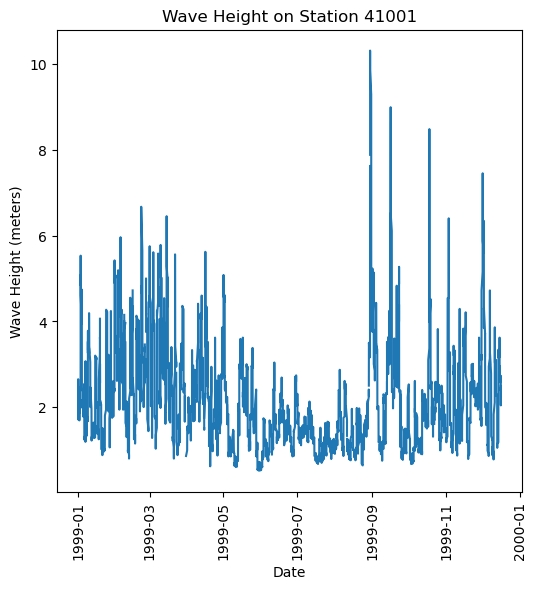

In [138]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Wave Height on Station 41001")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Wave Height (meters)")
plt.plot(dates, lm_wave_height)
plt.show()

## Wavelet Input Values

Wavelet inputs include:

- x: Input time-series data (for example, the time and wave height of data)
- wavelet: mother wavelet name
- dt: sampling period (time between each y-value)
- s0: smallest scale
- dj: spacing between each discrete scales
- jtot: largest scale

In [119]:
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 64  # largest scale

**For this example, we will be using a complex Morlet with a bandwidth of 1.5 and a center frequency of 1**

In [120]:
bandwidth = 1.5
center_freq = 1
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.5-1


## Applying Wavelets

[17688.975       2528.04664615  1315.71501602 ...   200.63877709
  1315.71501602  2528.04664615]
[ 0.00000000e+00  6.61375661e-08  1.32275132e-07 ... -1.98412698e-07
 -1.32275132e-07 -6.61375661e-08]


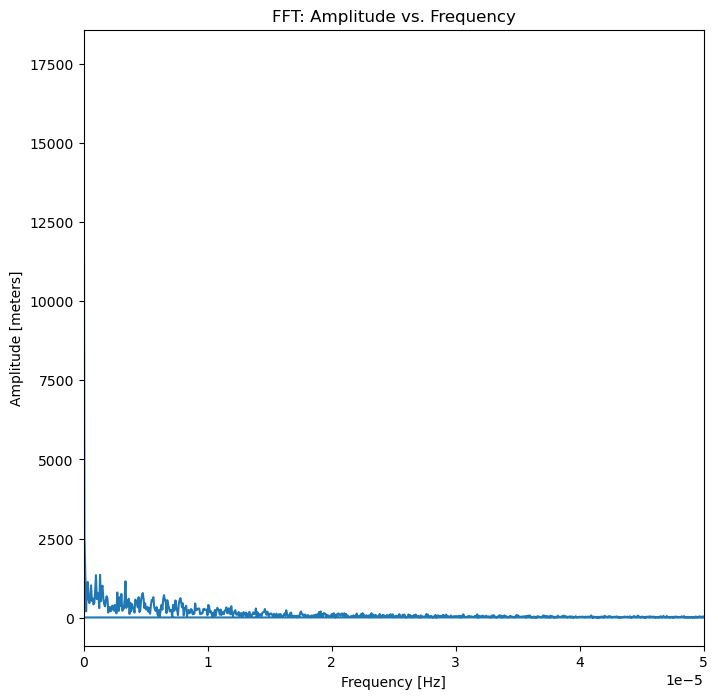

In [139]:
#from scipy.fftpack import fft, fftfreq      # working with Fourier Transforms

lm_len = np.arange(len(lm_wave_height))
mask = np.isfinite(lm_wave_height)
xfiltered = np.interp(lm_len, lm_len[mask], lm_wave_height[mask])
fft_mag = np.abs(np.fft.fft(xfiltered)) # estimated amplitude
fft_freq = np.fft.fftfreq(len(lm_wave_height), 1800) # 30 minute interval (60*30)
print(fft_mag)
print(fft_freq)

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(fft_freq, fft_mag)
plt.xlim(0, 0.00005)
plt.title("FFT: Amplitude vs. Frequency")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [meters]")
plt.show()

In [140]:
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=xfiltered, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)

f = pywt.scale2frequency(wavelet_mother, scales)/dt
#print(f)

## Power Spectrum
The power spectrum is the real component of the wavelet coefficients. We can find this value by squaring the absolute value of the `wavelet_coeffs` to return the magnitude of the real component to make a better graph.

In [145]:
power = np.power((abs(wavelet_coeffs)), 2)

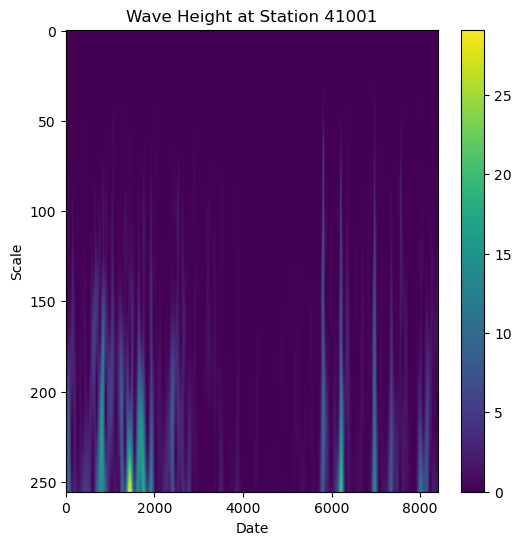

In [147]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), aspect="auto"
)

plt.title("Wave Height at Station 41001")
plt.xlabel("Date")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

The power spectrum above demonstrates a strong peak (in yellow) at  ...[TODO]

---

## Summary
TODO

### What's next?

- [Learn how more about PyWavelets](https://pywavelets.readthedocs.io/en/latest/regression/index.html)


## Resources and references

- ["A Practical Guide to Wavelet Analysis" (Torrence and Compo, 1998)](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf)